In [ ]:
# -----------------------------------------------------------------------------
# Customer Segmentation using K-Means Clustering
# -----------------------------------------------------------------------------
# This notebook performs customer segmentation on preprocessed marketing data.
# The goal is to identify distinct customer groups based on purchasing behavior,
# demographics, and engagement metrics to enable targeted marketing strategies.
#
# Business Context: 
# The company currently uses broad, non-personalized campaigns. By identifying
# natural customer segments, we can tailor marketing efforts, improve ROI,
# and increase campaign conversion rates.
# -----------------------------------------------------------------------------


In [1]:
#  1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

import warnings
warnings.filterwarnings('ignore')

# Set style for better visuals
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')


In [ ]:
#  2. Load Preprocessed Data
# 
# Using the cleaned dataset from preprocessing step. This version has:
# - Missing incomes imputed
# - Outliers removed (age > 100, extreme income)
# - Constant columns dropped
# - Log-transformed spending variables
# - Engineered features (Age, Tenure, Family_Size, etc.)

# Load the preprocessed data
df = pd.read_csv('../../data/preprocessed/marketing_campaign_preprocessed.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()


# Quick check for any remaining issues
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"\nData types:")
df.info()

Dataset shape: (2229, 28)

First few rows:
Missing values: 0

Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2229 entries, 0 to 2228
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Education             2229 non-null   object 
 1   Income                2229 non-null   float64
 2   Recency               2229 non-null   int64  
 3   MntWines              2229 non-null   float64
 4   MntFruits             2229 non-null   float64
 5   MntMeatProducts       2229 non-null   float64
 6   MntFishProducts       2229 non-null   float64
 7   MntSweetProducts      2229 non-null   float64
 8   MntGoldProds          2229 non-null   float64
 9   NumDealsPurchases     2229 non-null   int64  
 10  NumWebPurchases       2229 non-null   int64  
 11  NumCatalogPurchases   2229 non-null   int64  
 12  NumStorePurchases     2229 non-null   int64  
 13  NumWebVisitsMonth     2229 non-null   int64  
 14

In [ ]:
#  3. Feature Selection for Clustering
# 
# **Rationale:**
# I'm selecting features that capture both customer demographics and behavior.
# This mix should produce segments that are both meaningful (who they are) 
# and actionable (how they shop).
# 
# **Features included:**
# - **Demographics**: Age, Income, Family_Size, Education (encoded), Living_With
# - **Spending behavior**: Individual product categories (already log-transformed)
# - **Purchase channels**: Web, Catalog, Store, Deal purchases
# - **Engagement**: Recency, Tenure, Web visits
# 
# **Features excluded:**
# - Campaign acceptance columns: These are outcomes we want to predict later,
#   not inputs for segmentation. Including them would bias clusters toward
#   past campaign performance rather than natural customer behavior.
# - Total_Spending: Redundant since we have individual categories
# - ID, Dt_Customer: Not useful for clustering


# Define feature sets for clarity
demographic_features = ['Age', 'Income', 'Family_Size', 'Children_at_home']
spending_features = ['MntWines', 'MntFruits', 'MntMeatProducts', 
                     'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
purchase_features = ['NumDealsPurchases', 'NumWebPurchases', 
                     'NumCatalogPurchases', 'NumStorePurchases']
engagement_features = ['Recency', 'Customer_Tenure_Days', 'NumWebVisitsMonth']

# Combine all features for clustering
features_to_cluster = (demographic_features + spending_features + 
                       purchase_features + engagement_features)

print(f"Selected features ({len(features_to_cluster)} total):")
for feat in features_to_cluster:
    print(f"  - {feat}")


# Extract feature matrix
X = df[features_to_cluster].copy()

# Check for any infinite or extreme values
print(f"\nFeature statistics:")
X.describe().T

Selected features (17 total):
  - Age
  - Income
  - Family_Size
  - Children_at_home
  - MntWines
  - MntFruits
  - MntMeatProducts
  - MntFishProducts
  - MntSweetProducts
  - MntGoldProds
  - NumDealsPurchases
  - NumWebPurchases
  - NumCatalogPurchases
  - NumStorePurchases
  - Recency
  - Customer_Tenure_Days
  - NumWebVisitsMonth

Feature statistics:


,count,mean,std,min,25%,50%,75%,max
Age,2229.0,57.111261,11.707430,30.0,49.000000,56.000000,67.000000,86.000000
Income,2229.0,51619.504262,20601.216248,1730.0,35416.000000,51381.500000,68118.000000,113734.000000
Family_Size,2229.0,2.596231,0.907432,1.0,2.000000,3.000000,3.000000,5.000000
Children_at_home,2229.0,0.951996,0.751976,0.0,0.000000,1.000000,1.000000,3.000000
MntWines,2229.0,4.682330,1.800136,0.0,3.218876,5.176150,6.226537,7.309212
MntFruits,2229.0,2.242687,1.570153,0.0,1.098612,2.197225,3.526361,5.298317
MntMeatProducts,2229.0,4.128059,1.554425,0.0,2.833213,4.219508,5.446737,7.453562
MntFishProducts,2229.0,2.538682,1.658498,0.0,1.386294,2.564949,3.931826,5.560682
MntSweetProducts,2229.0,2.245432,1.594124,0.0,0.693147,2.197225,3.555348,5.575949
MntGoldProds,2229.0,3.127559,1.284325,0.0,2.302585,3.218876,4.043051,5.894403


In [ ]:
#  4. Handle Categorical Variables
# 
# Education and Living_With are categorical and need encoding.
# I'll use one-hot encoding since these have few categories and we want
# to preserve the distinction between education levels and living situations.

# First, get the categorical columns from original dataframe
categorical_features = ['Education', 'Living_With']

# Get dummy variables
df_dummies = pd.get_dummies(df[categorical_features], prefix=['edu', 'live'])

# Combine with numerical features
X_encoded = pd.concat([X, df_dummies], axis=1)

print(f"Shape after encoding: {X_encoded.shape}")
print(f"\nFeatures now include:")
X_encoded.columns.tolist()

Shape after encoding: (2229, 23)

Features now include:


['Age',
 'Income',
 'Family_Size',
 'Children_at_home',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'Recency',
 'Customer_Tenure_Days',
 'NumWebVisitsMonth',
 'edu_Graduate',
 'edu_PhD',
 'edu_Postgraduate',
 'edu_Undergraduate',
 'live_Alone',
 'live_Partner']

In [ ]:

# 5. Feature Scaling
# 
# **Why scaling matters:**
# K-Means uses Euclidean distance, so features with larger magnitudes 
# (Income in thousands, Tenure in thousands) would dominate features 
# with smaller ranges (Recency 0-100) if not scaled.
# 
# I'm using StandardScaler which standardizes to mean=0, std=1.
# This is appropriate because:
# - Our features are roughly continuous
# - We don't have extreme outliers (already handled in preprocessing)
# - It preserves the relative relationships between data points


# Initialize scaler
scaler = StandardScaler()

# Fit and transform the data
X_scaled = scaler.fit_transform(X_encoded)

# Convert back to DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=X_encoded.columns)

print("Feature scaling complete.")
print(f"Scaled data shape: {X_scaled_df.shape}")
print(f"\nFirst few rows of scaled data:")
X_scaled_df.head()


Feature scaling complete.
Scaled data shape: (2229, 23)

First few rows of scaled data:


,Age,Income,Family_Size,Children_at_home,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,NumStorePurchases,Recency,Customer_Tenure_Days,NumWebVisitsMonth,edu_Graduate,edu_PhD,edu_Postgraduate,edu_Undergraduate,live_Alone,live_Partner
0,1.015715,0.316484,-1.759459,-1.266277,0.985074,1.430723,1.400440,1.576847,1.407487,1.059999,...,-0.559160,0.307314,1.529265,0.689920,0.991512,-0.524568,-0.445407,-0.359415,1.345676,-1.345676
1,1.272020,-0.256135,0.445057,1.393978,-1.220972,-0.987093,-1.404146,-0.868492,-0.973973,-0.920261,...,-1.176175,-0.383771,-1.190769,-0.138430,0.991512,-0.524568,-0.445407,-0.359415,1.345676,-1.345676
2,0.332234,0.970719,-0.657201,-1.266277,0.763699,1.063407,0.465853,1.314627,0.530574,0.493476,...,1.291882,-0.798422,-0.206611,-0.552605,0.991512,-0.524568,-0.445407,-0.359415,-0.743121,0.743121
3,-1.291031,-1.212506,0.445057,0.063851,-1.220972,-0.403394,-0.697223,-0.084907,-0.539061,-1.040313,...,-0.559160,-0.798422,-1.062186,0.275745,0.991512,-0.524568,-0.445407,-0.359415,-0.743121,0.743121
4,-1.034726,0.324010,0.445057,0.063851,0.264887,0.981974,0.418940,0.790933,0.681890,-0.276449,...,0.057854,1.551268,-0.953384,-0.138430,-1.008561,1.906330,-0.445407,-0.359415,-0.743121,0.743121


k=2: Inertia=38627, Silhouette=0.2226
k=3: Inertia=35158, Silhouette=0.1595
k=4: Inertia=32925, Silhouette=0.1395
k=5: Inertia=31070, Silhouette=0.1334
k=6: Inertia=29515, Silhouette=0.1429
k=7: Inertia=28643, Silhouette=0.1418
k=8: Inertia=27490, Silhouette=0.1315
k=9: Inertia=26605, Silhouette=0.1364
k=10: Inertia=25681, Silhouette=0.1476


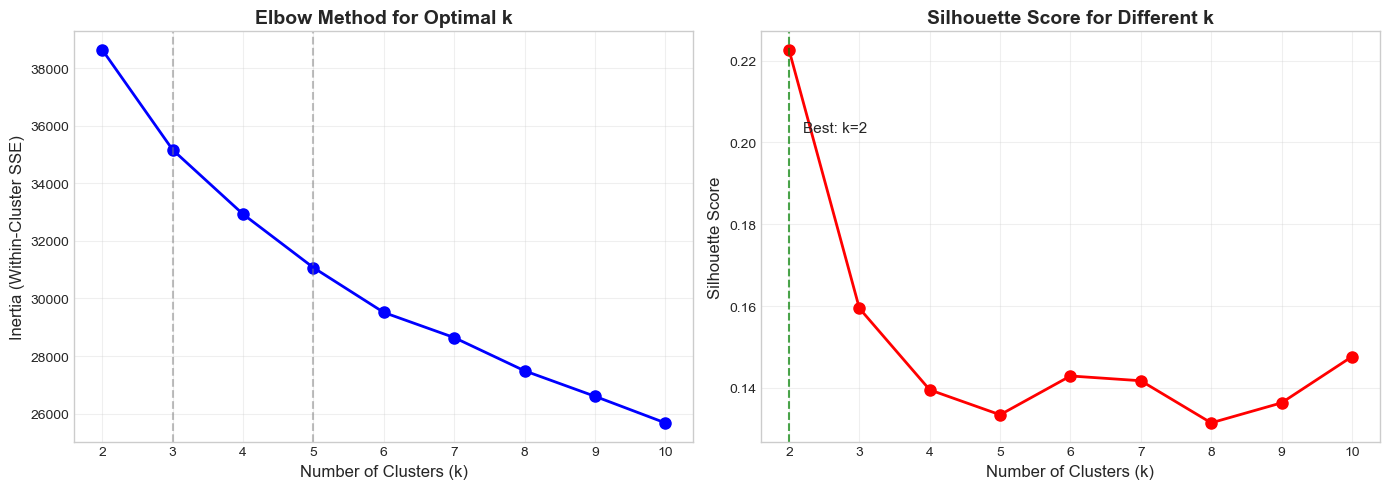

In [9]:
# 6. Finding the Optimal Number of Clusters
# 
# I'll use two complementary methods:
# 
# 1. **Elbow Method**: Plots inertia (within-cluster sum of squares) vs k.
#    The "elbow" where improvement slows suggests a good k.
# 
# 2. **Silhouette Score**: Measures cluster cohesion vs separation.
#    Range: -1 to 1. Higher = better defined clusters.
#    >0.5 = reasonable, >0.7 = strong structure.
# 
# I'll test k from 2 to 10. Beyond 10 becomes hard to interpret for
# marketing teams (too many segments to action).

# Test different k values
k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled_df)
    
    # Store metrics
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled_df, cluster_labels)
    silhouette_scores.append(sil_score)
    
    print(f"k={k}: Inertia={kmeans.inertia_:.0f}, Silhouette={sil_score:.4f}")


# Plot Elbow Curve and Silhouette Scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster SSE)', fontsize=12)
axes[0].set_title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Add annotations for potential elbows
axes[0].axvline(x=3, color='gray', linestyle='--', alpha=0.5)
axes[0].axvline(x=5, color='gray', linestyle='--', alpha=0.5)

# Silhouette plot
axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score for Different k', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Highlight best silhouette
best_k_sil = k_range[np.argmax(silhouette_scores)]
axes[1].axvline(x=best_k_sil, color='green', linestyle='--', alpha=0.7)
axes[1].text(best_k_sil+0.2, max(silhouette_scores)-0.02, 
             f'Best: k={best_k_sil}', fontsize=11)

plt.tight_layout()
plt.show()